Datasets and Models used: https://drive.google.com/drive/folders/1lBSYGSWRQDu0s_kzZ3G0YKbSF_BZgayr?usp=drive_link

# Importing Libraries

In [ ]:
import pandas as pd
import plotly.express as px
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt


## Data Fetching and pre-processing

In [ ]:
df = pd.read_parquet('normalised_data.parquet')
df

,time,total_amount,mean_amount,mean_fare_amount,passenger_count,mean_passenger_per_trip,total_trip_distance,mean_trip_distance,number_trips
0,2011-01-01 00:00:00,0.241932,0.084480,0.205726,0.196542,1.630985,0.345569,0.257040,0.227363
1,2011-01-01 01:00:00,0.280106,0.100345,0.225582,0.219872,1.661980,0.404502,0.276820,0.249608
2,2011-01-01 02:00:00,0.252626,0.101716,0.226668,0.193952,1.632797,0.374753,0.286956,0.224117
3,2011-01-01 03:00:00,0.222074,0.102202,0.226325,0.165042,1.583062,0.343214,0.301243,0.196702
4,2011-01-01 04:00:00,0.169204,0.111931,0.238638,0.116491,1.512791,0.271299,0.325307,0.145286
...,...,...,...,...,...,...,...,...,...
113135,2023-11-30 19:00:00,0.399727,0.551558,0.515329,0.102551,1.343112,0.241533,0.287825,0.144059
113136,2023-11-30 20:00:00,0.362646,0.507927,0.510040,0.099231,1.350020,0.247325,0.308807,0.138682
113137,2023-11-30 21:00:00,0.353881,0.476736,0.480066,0.103891,1.385149,0.238547,0.289608,0.141512
113138,2023-11-30 22:00:00,0.345732,0.485349,0.489610,0.098081,1.355396,0.247708,0.314880,0.136531


In [ ]:
class DateTimeEncoder:
    def __init__(self):
        self.date_mapping = {}
        self.day_mapping = {}
        self.month_mapping = {}
        self.hour_mapping = {}

    def fit(self, datetime_column):
        # Create a mapping of datetime values to ordinal numbers
        unique_dates = sorted(datetime_column.dt.date.unique())
        unique_days = sorted(datetime_column.dt.day.unique())
        unique_months = sorted(datetime_column.dt.month.unique())
        unique_hours = sorted(datetime_column.dt.hour.unique())

        self.date_mapping = {date: i+1 for i, date in enumerate(unique_dates)}
        self.day_mapping = {day: i+1 for i, day in enumerate(unique_days)}
        self.month_mapping = {month: i+1 for i, month in enumerate(unique_months)}
        self.hour_mapping = {hour: i+1 for i, hour in enumerate(unique_hours)}

    def transform(self, datetime_column):
        # Transform datetime values to ordinal numbers using the mapping
        encoded_date = datetime_column.dt.date.map(self.date_mapping)
        encoded_day = datetime_column.dt.day.map(self.day_mapping)
        encoded_month = datetime_column.dt.month.map(self.month_mapping)
        encoded_hour = datetime_column.dt.hour.map(self.hour_mapping)
        return encoded_date, encoded_day, encoded_month, encoded_hour

    def inverse_transform(self, encoded_date, encoded_day, encoded_month, encoded_hour):
        # Retrieve the original datetime values from the encoded numbers
        decoded_date = encoded_date.map({v: k for k, v in self.date_mapping.items()})
        decoded_day = encoded_day.map({v: k for k, v in self.day_mapping.items()})
        decoded_month = encoded_month.map({v: k for k, v in self.month_mapping.items()})
        decoded_hour = encoded_hour.map({v: k for k, v in self.hour_mapping.items()})
        return decoded_date, decoded_day, decoded_month, decoded_hour


In [ ]:
# Initialize and fit the encoder
encoder = DateTimeEncoder()
encoder.fit(df['time'])

# Encode datetime values
df['encoded_date'], df['day'], df['month'], df['hour'] = encoder.transform(df['time'])
# Decode ordinal numbers back to datetime values
# decoded_date, decoded_day, decoded_month = encoder.inverse_transform(encoded_date, encoded_day, encoded_month)


In [ ]:
data = df.drop(['time'], axis=1)
data

,total_amount,mean_amount,mean_fare_amount,passenger_count,mean_passenger_per_trip,total_trip_distance,mean_trip_distance,number_trips,encoded_date,day,month,hour
0,0.241932,0.084480,0.205726,0.196542,1.630985,0.345569,0.257040,0.227363,1,1,1,1
1,0.280106,0.100345,0.225582,0.219872,1.661980,0.404502,0.276820,0.249608,1,1,1,2
2,0.252626,0.101716,0.226668,0.193952,1.632797,0.374753,0.286956,0.224117,1,1,1,3
3,0.222074,0.102202,0.226325,0.165042,1.583062,0.343214,0.301243,0.196702,1,1,1,4
4,0.169204,0.111931,0.238638,0.116491,1.512791,0.271299,0.325307,0.145286,1,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
113135,0.399727,0.551558,0.515329,0.102551,1.343112,0.241533,0.287825,0.144059,4717,30,11,20
113136,0.362646,0.507927,0.510040,0.099231,1.350020,0.247325,0.308807,0.138682,4717,30,11,21
113137,0.353881,0.476736,0.480066,0.103891,1.385149,0.238547,0.289608,0.141512,4717,30,11,22
113138,0.345732,0.485349,0.489610,0.098081,1.355396,0.247708,0.314880,0.136531,4717,30,11,23


In [ ]:
ratio = (data.number_trips.max()-data.number_trips.min())**2

In [ ]:
# Save DataFrame to CSV
data.to_csv('data_with_datetime_features_used_as_condition.csv', index=False)

# Download CSV file from Kaggle Notebook
from IPython.display import FileLink
FileLink('data_with_datetime_features_used_as_condition.csv')  # This will create a download link for the CSV file


/content/data_with_datetime_features_used_as_condition.csv

In [ ]:
def unnormalize_data(df, column, max_value):
        df[column] = df[column] * (max_value - df[column].min()) + df[column].min()
        return df[column]

max_values = [600*1e3,50,35,100*1e3,100*1e3,10,53*1e3]

## Data Visualization

In [ ]:
# Group the data by date and aggregate the values
daily_data = df.groupby('encoded_date').agg({
    'total_amount': 'sum',
    'mean_amount': 'mean',
    'mean_fare_amount': 'mean',
    'passenger_count': 'mean',
    'mean_passenger_per_trip': 'mean',
    'total_trip_distance': 'sum',
    'mean_trip_distance': 'mean',
    'number_trips': 'sum'
}).reset_index()
daily_data['number_trips'] = unnormalize_data(daily_data, 'number_trips', 53*1e3)
# Plot day-wise number of trip records
fig = px.bar(daily_data, x='encoded_date', y='number_trips', title='Number of Trip Records per Day')
fig.update_xaxes(title='Encoded Date')
fig.update_yaxes(title='Number of Trip Records')
fig.show()


In [ ]:
# Group the data by month and aggregate the values
monthly_data = df.groupby('month').agg({
    'total_amount': 'sum',
    'mean_amount': 'mean',
    'mean_fare_amount': 'mean',
    'passenger_count': 'mean',
    'mean_passenger_per_trip': 'mean',
    'total_trip_distance': 'sum',
    'mean_trip_distance': 'mean',
    'number_trips': 'sum'
}).reset_index()
monthly_data['number_trips'] = unnormalize_data(monthly_data, 'number_trips', 53*1e3)

# Plot month-wise number of trip records
fig = px.bar(monthly_data, x='month', y='number_trips', title='Number of Trip Records per Month')
fig.update_xaxes(title='Month')
fig.update_yaxes(title='Number of Trip Records')
fig.show()


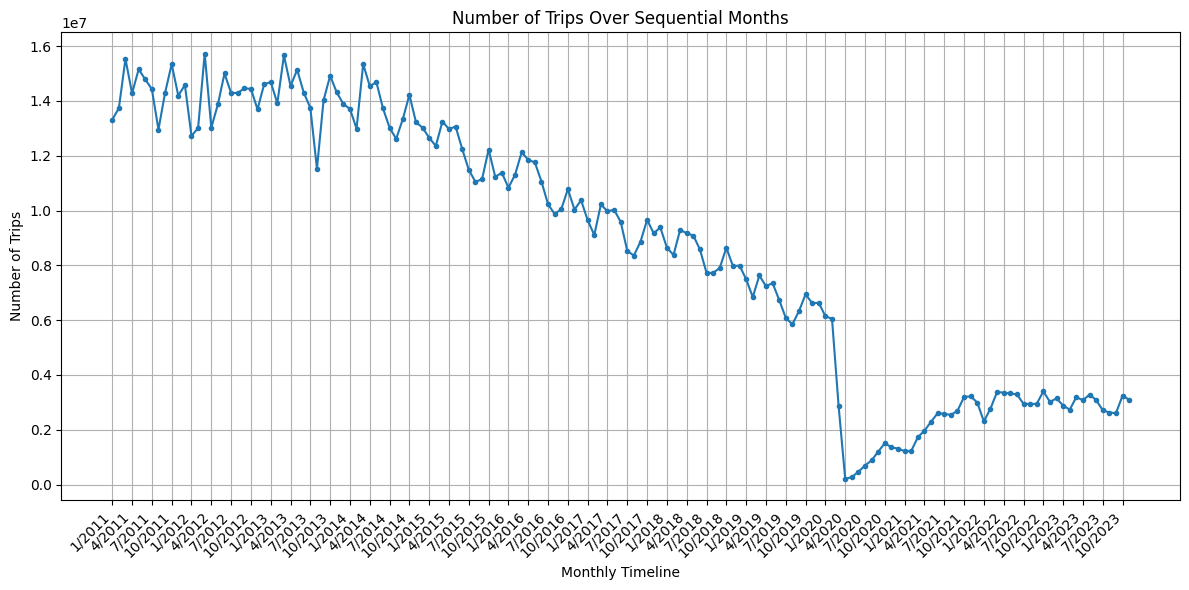

In [ ]:
def aggregate_data_over_sequential_months(df):
    # Extract month and year from the datetime column
    df['year'] = df['time'].dt.year
    df['month'] = df['time'].dt.month

    # Group the data by month and year, and aggregate the values
    monthly_data = df.groupby(['year', 'month']).agg({
        'total_amount': 'sum',
        'mean_amount': 'mean',
        'mean_fare_amount': 'mean',
        'passenger_count': 'mean',
        'mean_passenger_per_trip': 'mean',
        'total_trip_distance': 'mean',
        'mean_trip_distance': 'mean',
        'number_trips': 'sum'
    }).reset_index()

    return monthly_data

# Call the function to get the aggregated dataset
sequential_monthly_aggregated_data = aggregate_data_over_sequential_months(df)
sequential_monthly_aggregated_data

timeline = []
for year in range(2011,2024):
    for month in range(1,13):
        timeline.append(f"{str(month)}/{str(year)}")

import matplotlib.pyplot as plt

# Plot the aggregated data
plt.figure(figsize=(12, 6))
# plt.plot(timeline[:-1], sequential_monthly_aggregated_data['number_trips'], marker='.')
plt.plot(timeline[:-1], unnormalize_data(sequential_monthly_aggregated_data, 'number_trips',53*1e3), marker='.')
plt.title('Number of Trips Over Sequential Months')
plt.xlabel('Monthly Timeline')
plt.ylabel('Number of Trips')
plt.grid(True)
plt.xticks(timeline[:-1][::3], rotation=45, ha='right')  # Display every 3rd tick label and rotate
plt.tight_layout()
plt.show()


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113140 entries, 0 to 113139
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   total_amount             113140 non-null  float64
 1   mean_amount              113140 non-null  float64
 2   mean_fare_amount         113140 non-null  float64
 3   passenger_count          113140 non-null  float64
 4   mean_passenger_per_trip  113140 non-null  float64
 5   total_trip_distance      113140 non-null  float64
 6   mean_trip_distance       113140 non-null  float64
 7   number_trips             113140 non-null  float64
 8   encoded_date             113140 non-null  int64  
 9   day                      113140 non-null  int64  
 10  month                    113140 non-null  int64  
 11  hour                     113140 non-null  int64  
dtypes: float64(8), int64(4)
memory usage: 10.4 MB


In [ ]:
lstm_data = data.iloc[:,:7]
output_data = data.iloc[:,7]
condition_data=data.iloc[:,8:]
lstm_data.info(), output_data.info(), condition_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113140 entries, 0 to 113139
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   total_amount             113140 non-null  float64
 1   mean_amount              113140 non-null  float64
 2   mean_fare_amount         113140 non-null  float64
 3   passenger_count          113140 non-null  float64
 4   mean_passenger_per_trip  113140 non-null  float64
 5   total_trip_distance      113140 non-null  float64
 6   mean_trip_distance       113140 non-null  float64
dtypes: float64(7)
memory usage: 6.0 MB
<class 'pandas.core.series.Series'>
RangeIndex: 113140 entries, 0 to 113139
Series name: number_trips
Non-Null Count   Dtype  
--------------   -----  
113140 non-null  float64
dtypes: float64(1)
memory usage: 884.0 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113140 entries, 0 to 113139
Data columns (total 4 columns):
 #   Column        Non-Nul

(None, None, None)

In [ ]:
# Define a function to create sequences
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        sequences.append(seq)
    return sequences

# Define custom dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, data_input, data_condition, data_output, input_seq_length, output_seq_length):
        self.sequences_output = create_sequences(data_output, output_seq_length)
        self.sequences_input = create_sequences(data_input, input_seq_length)[:len(self.sequences_output)]
        self.sequences_condition = create_sequences(data_condition, input_seq_length)[:len(self.sequences_output)]

    def __len__(self):
        return len(self.sequences_input)

    def __getitem__(self, idx):
        return (torch.tensor(self.sequences_input[idx], dtype=torch.float32), torch.tensor(self.sequences_condition[idx], dtype=torch.float32), \
        torch.tensor(self.sequences_output[idx], dtype=torch.float32))



In [ ]:
input_seq_length = 24*7  # Set the input sequence length
output_seq_length = 24
dataset = TimeSeriesDataset(lstm_data.values,condition_data.values, output_data.values[168:], input_seq_length, output_seq_length)

In [ ]:
for i,c,o in dataset:
  print(i.shape, c.shape, o.shape)
  break


torch.Size([168, 7]) torch.Size([168, 4]) torch.Size([24])


In [ ]:
train_dataset = dataset[:-30*24]
test_dataset = dataset[-30*24:]
train_dataset = list(zip(*train_dataset)) #transpose (3,n) tuple to (n,3)
test_dataset = list(zip(*test_dataset))

<ipython-input-21-df242f65d9eb>:23: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)



In [ ]:
# Convert train dataset to DataLoader
train_loader = DataLoader(train_dataset, batch_size=64)


# # Convert test dataset to DataLoader
test_loader = DataLoader(test_dataset, batch_size=64)

# LSTM Architecture

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, condition_size, output_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.condition_size = condition_size
        self.output_size = output_size

        # LSTM layers for input sequence and condition sequence
        self.lstm_input = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm_condition = nn.LSTM(condition_size, hidden_size, num_layers, batch_first=True)

        # Fully connected layer to predict next n sequences
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, input_seq, condition_seq):
        batch_size = input_seq.size(0)

        # Initial hidden and cell states for input sequence LSTM
        h0_input = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(input_seq.device)
        c0_input = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(input_seq.device)

        # LSTM forward pass for input sequence
        lstm_out_input, _ = self.lstm_input(input_seq, (h0_input, c0_input))

        # Initial hidden and cell states for condition sequence LSTM
        h0_condition = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(condition_seq.device)
        c0_condition = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(condition_seq.device)

        # LSTM forward pass for condition sequence
        lstm_out_condition, _ = self.lstm_condition(condition_seq, (h0_condition, c0_condition))

        # Take the last element of LSTM output sequences
        lstm_out_input_last = lstm_out_input[:, -1, :]
        lstm_out_condition_last = lstm_out_condition[:, -1, :]
        # Concatenate LSTM outputs
        combined = torch.cat((lstm_out_input_last, lstm_out_condition_last), dim=1)
        # Fully connected layer for predicting next n sequences
        fc_output = self.fc(combined)

        return fc_output


# RNN Architecture

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, condition_size, output_size):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.condition_size = condition_size
        self.output_size = output_size

        # RNN layers for input sequence and condition sequence
        self.rnn_input = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.rnn_condition = nn.RNN(condition_size, hidden_size, num_layers, batch_first=True)

        # Fully connected layer to predict next n sequences
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, input_seq, condition_seq):
        batch_size = input_seq.size(0)

        # Initial hidden states for input sequence RNN
        h0_input = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(input_seq.device)

        # RNN forward pass for input sequence
        rnn_out_input, _ = self.rnn_input(input_seq, h0_input)

        # Initial hidden states for condition sequence RNN
        h0_condition = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(condition_seq.device)

        # RNN forward pass for condition sequence
        rnn_out_condition, _ = self.rnn_condition(condition_seq, h0_condition)

        # Take the last element of RNN output sequences
        rnn_out_input_last = rnn_out_input[:, -1, :]
        rnn_out_condition_last = rnn_out_condition[:, -1, :]

        # Concatenate RNN outputs
        combined = torch.cat((rnn_out_input_last, rnn_out_condition_last), dim=1)

        # Fully connected layer for predicting next n sequences
        fc_output = self.fc(combined)

        return fc_output


# GRU Architecture

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, condition_size, output_size):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.condition_size = condition_size
        self.output_size = output_size

        # GRU layers for input sequence and condition sequence
        self.gru_input = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.gru_condition = nn.GRU(condition_size, hidden_size, num_layers, batch_first=True)

        # Fully connected layer to predict next n sequences
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, input_seq, condition_seq):
        batch_size = input_seq.size(0)

        # Initial hidden states for input sequence GRU
        h0_input = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(input_seq.device)

        # GRU forward pass for input sequence
        gru_out_input, _ = self.gru_input(input_seq, h0_input)

        # Initial hidden states for condition sequence GRU
        h0_condition = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(condition_seq.device)

        # GRU forward pass for condition sequence
        gru_out_condition, _ = self.gru_condition(condition_seq, h0_condition)

        # Take the last element of GRU output sequences
        gru_out_input_last = gru_out_input[:, -1, :]
        gru_out_condition_last = gru_out_condition[:, -1, :]

        # Concatenate GRU outputs
        combined = torch.cat((gru_out_input_last, gru_out_condition_last), dim=1)

        # Fully connected layer for predicting next n sequences
        fc_output = self.fc(combined)

        return fc_output


In [ ]:
# Choose device (CUDA if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training Function

In [ ]:
def train(model, train_loader, num_epochs, optimizer, loss_fn, model_name, device=device, plot=True):
  training_loss = []
  model.train()  # Set the model to training mode
  # Training loop
  for epoch in range(num_epochs):
      total_loss = 0.0
      for input_seq, condition_seq, target_seq in train_loader:
          input_seq, condition_seq, target_seq = input_seq.to(device), condition_seq.to(device), target_seq.to(device)
          optimizer.zero_grad()  # Clear gradients
          # Forward pass
          fc_output = model(input_seq, condition_seq)
          # Calculate loss
          loss = loss_fn(target_seq, fc_output)
          total_loss += loss.item()
          # Backward pass
          loss.backward()
          optimizer.step()  # Update weights
      training_loss.append(total_loss / len(train_loader))
      print(f"Epoch {epoch+1}, Training Loss: {total_loss / len(train_loader)}")

  # Plot actual vs predicted number of trips
  plt.figure(figsize=(10, 6))
  plt.plot(training_loss, color='blue')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title(f'{model_name} Training Loss over {num_epochs} epochs')
  plt.show()
  return training_loss



# Testing Function

In [ ]:
def test(model, test_loader):
  # Testing loop
  model.eval()
  with torch.no_grad():
      test_loss = 0.0
      predictions = []
      for input_seq, condition_seq, target_seq in test_loader:
          input_seq, condition_seq, target_seq = input_seq.to(device), condition_seq.to(device), target_seq.to(device)
          # Forward pass
          output = model(input_seq, condition_seq)
          # Append the predicted values
          predictions.append(output[:,-1].cpu().numpy())  # Convert predictions to numpy array
          # Calculate loss
          loss = nn.MSELoss()(target_seq, output)
          test_loss += loss.item()
      print(f"Test Loss: {test_loss / len(test_loader)}")
      return predictions,test_loss / len(test_loader)

# Plotting results

In [ ]:
def plot_test_results(predictions, actual_values, model_name):
  # Combine all predictions into a single numpy array
  predictions = np.concatenate(predictions, axis=0)
  predictions = predictions * (53*1e3 -output_data.min()) + output_data.min()
  actual_values = (output_data * (53*1e3 - output_data.min()) + output_data.min())

  # Plot actual vs predicted number of trips
  plt.figure(figsize=(10, 6))
  plt.plot(actual_values.index[-1000:-720], actual_values[-1000:-720], label='Actual Number of Trips (Training)', color='black')
  plt.plot(actual_values.index[-720:], actual_values[-720:], label='Actual Number of Trips (Testing)', color='green')
  plt.plot(actual_values.index[-720:], predictions, label='Predicted Number of Trips', color='red')
  plt.xlabel('Time Steps')
  plt.ylabel('Number of Trips')
  plt.title(f'Actual vs Predicted Number of Trips upon {model_name}')
  plt.legend()
  plt.show()


# Using Normal Sequence model training and testing

In [ ]:
input_size = 7
hidden_size = 128
num_layers = 2
condition_size = 4
output_size = 24
num_epochs = 10
# Convert target_seq to numpy array
actual_values = np.concatenate([target_seq[:,-1].cpu().numpy() for _, _, target_seq in test_loader], axis=0)

Epoch 1, Training Loss: 0.011230235722714673
Epoch 2, Training Loss: 0.003931079272318782
Epoch 3, Training Loss: 0.0030511001002954366
Epoch 4, Training Loss: 0.002768892362898691
Epoch 5, Training Loss: 0.0025963913837234445
Epoch 6, Training Loss: 0.0024006154492500166
Epoch 7, Training Loss: 0.0022360214690122027
Epoch 8, Training Loss: 0.0021326083461046504
Epoch 9, Training Loss: 0.0020242487607591035
Epoch 10, Training Loss: 0.0019330757580768687


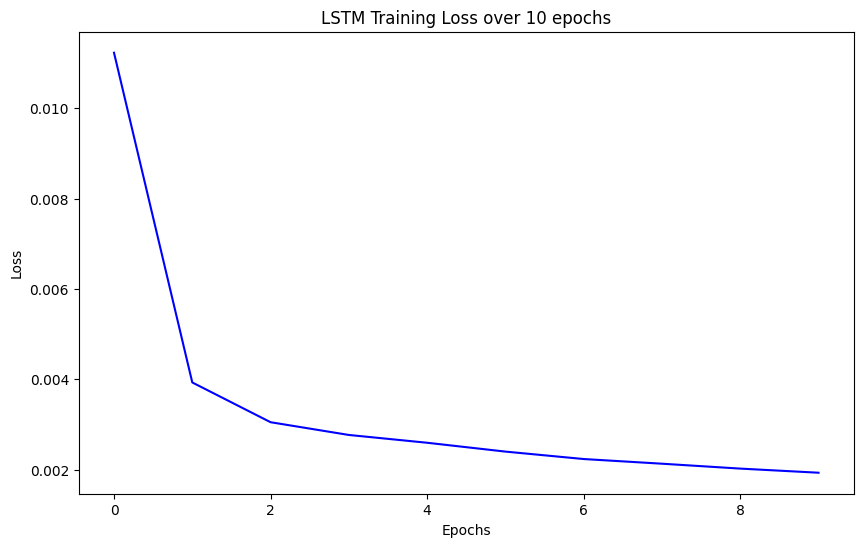

In [ ]:
model = LSTM(input_size, hidden_size, num_layers, condition_size, output_size)
# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()
# Move model to CUDA if available
model = model.to(device)
lstm_training_loss = train(model, train_loader, num_epochs, optimizer, loss_fn, model_name='LSTM', device=device, plot=True)

Test Loss: 0.0002771017279883381


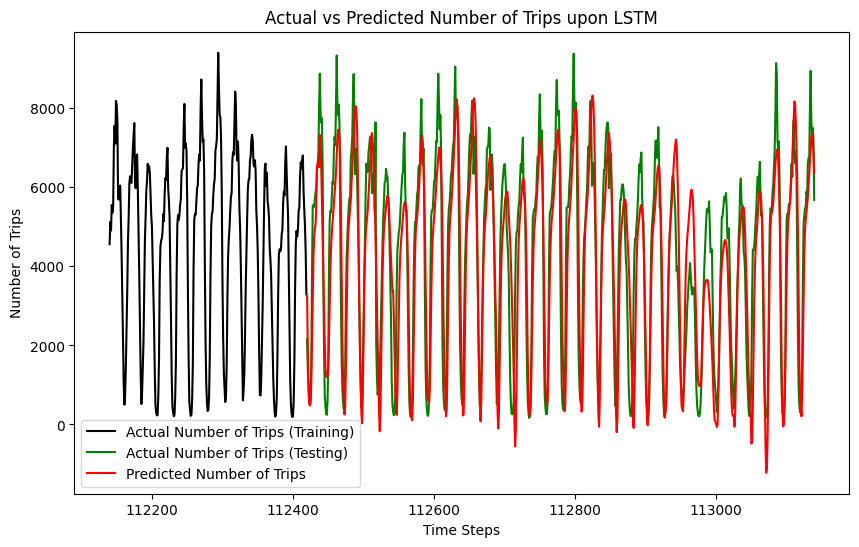

In [ ]:
# Save the model
torch.save(model.state_dict(), 'LSTM_model.pth')
predictions, _ = test(model, test_loader)
plot_test_results(predictions, actual_values, model_name = 'LSTM')

Epoch 1, Training Loss: 0.007556895762899825
Epoch 2, Training Loss: 0.004350296064066457
Epoch 3, Training Loss: 0.0036155228346652665
Epoch 4, Training Loss: 0.0030958747674035454
Epoch 5, Training Loss: 0.0027500866607548923
Epoch 6, Training Loss: 0.0025090128173782507
Epoch 7, Training Loss: 0.002416810684227382
Epoch 8, Training Loss: 0.0024070338883099454
Epoch 9, Training Loss: 0.0021915053549370522
Epoch 10, Training Loss: 0.0021144470521930678


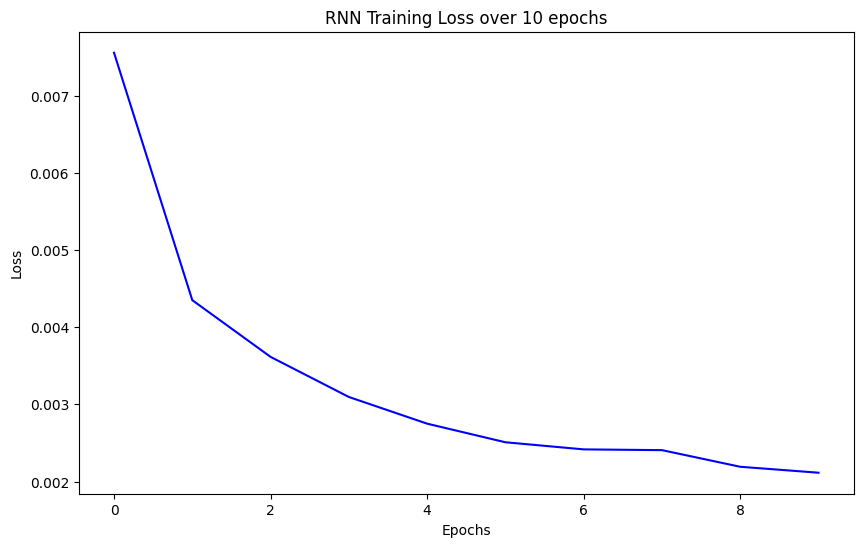

In [ ]:
model = RNN(input_size, hidden_size, num_layers, condition_size, output_size)
# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()
# Move model to CUDA if available
model = model.to(device)
rnn_training_loss = train(model, train_loader, num_epochs, optimizer, loss_fn, model_name='RNN', device=device, plot=True)

Test Loss: 0.00027566086282604374


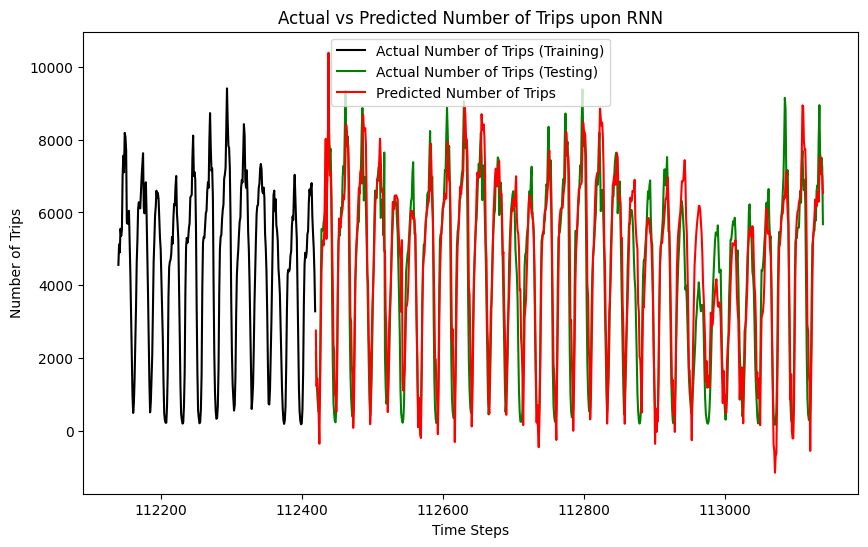

In [ ]:
# Save the model
torch.save(model.state_dict(), 'RNN_model.pth')
predictions, _ = test(model, test_loader)
plot_test_results(predictions, actual_values, model_name = 'RNN')

Epoch 1, Training Loss: 0.010234515207592219
Epoch 2, Training Loss: 0.004166053504392006
Epoch 3, Training Loss: 0.0035853253282636
Epoch 4, Training Loss: 0.0031963741462334577
Epoch 5, Training Loss: 0.0029238280684701734
Epoch 6, Training Loss: 0.0027018457673741894
Epoch 7, Training Loss: 0.0025434465052195858
Epoch 8, Training Loss: 0.00241152525502636
Epoch 9, Training Loss: 0.002313269520759983
Epoch 10, Training Loss: 0.0022347463343617593


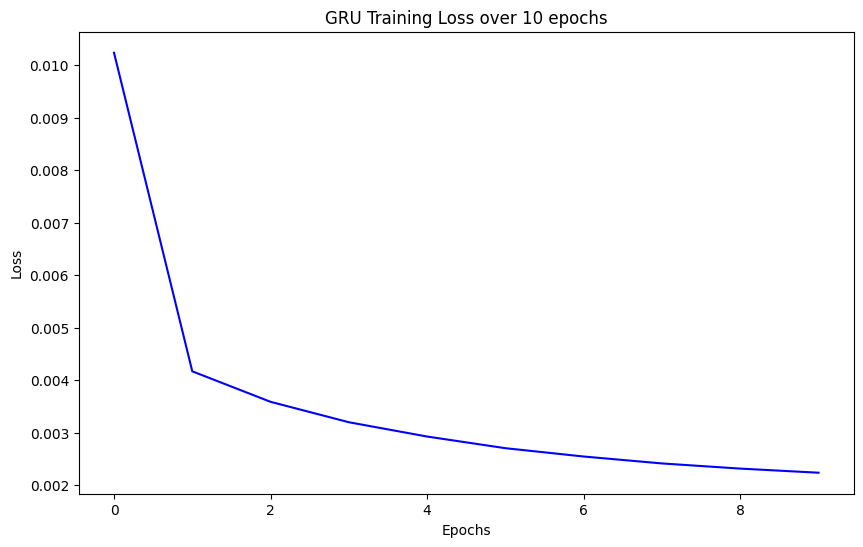

In [ ]:
model = GRU(input_size, hidden_size, num_layers, condition_size, output_size)
# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()
# Move model to CUDA if available
model = model.to(device)
gru_training_loss = train(model, train_loader, num_epochs, optimizer, loss_fn, model_name='GRU', device=device, plot=True)

Test Loss: 0.00032252441572685103


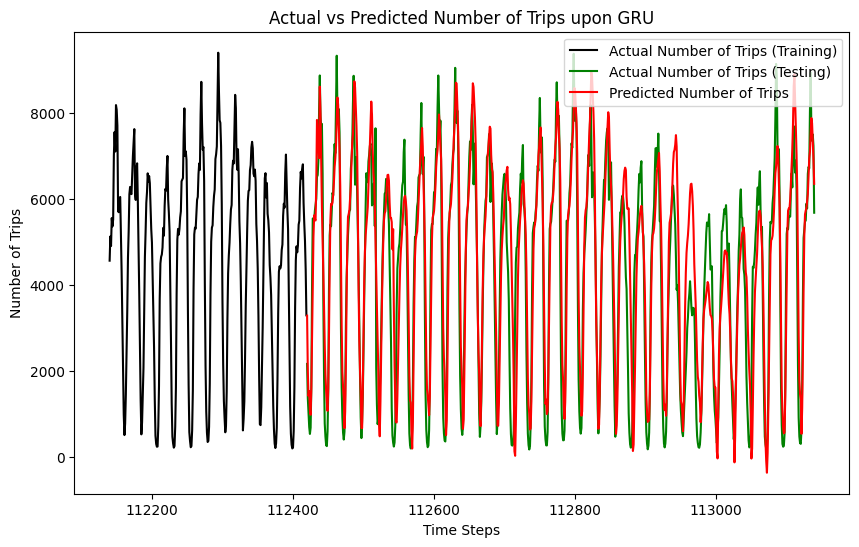

In [ ]:
# Save the model
torch.save(model.state_dict(), 'GRU_model.pth')
predictions, _ = test(model, test_loader)
plot_test_results(predictions, actual_values, model_name = 'GRU')

## Comparison Analysis

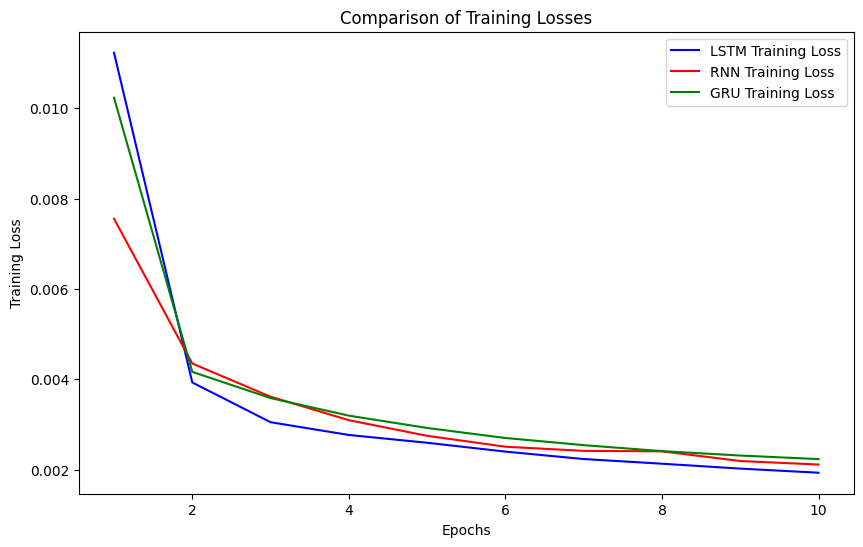

In [ ]:
# Plot training losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), lstm_training_loss, label='LSTM Training Loss', color='blue')
plt.plot(range(1, num_epochs+1), rnn_training_loss, label='RNN Training Loss', color='red')
plt.plot(range(1, num_epochs+1), gru_training_loss, label='GRU Training Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Comparison of Training Losses')
plt.legend()
plt.show()

Test Loss: 0.0002771017279883381
Test Loss: 0.00027566086282604374
Test Loss: 0.00032252441572685103


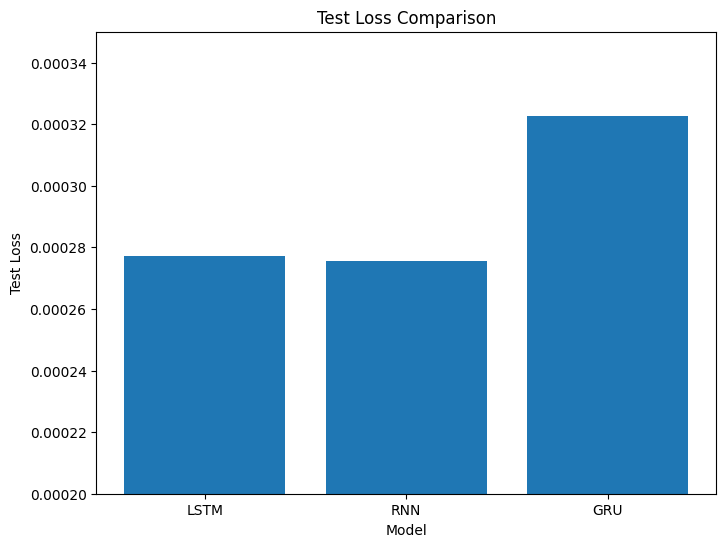

In [ ]:
lstm_model = LSTM(input_size, hidden_size, num_layers, condition_size, output_size).to(device)
state_dict = torch.load('LSTM_model.pth')
lstm_model.load_state_dict(state_dict)

rnn_model = RNN(input_size, hidden_size, num_layers, condition_size, output_size).to(device)
state_dict = torch.load('RNN_model.pth')
rnn_model.load_state_dict(state_dict)

gru_model = GRU(input_size, hidden_size, num_layers, condition_size, output_size).to(device)
state_dict = torch.load('GRU_model.pth')
gru_model.load_state_dict(state_dict)

_, test_loss_lstm = test(lstm_model, test_loader)
_, test_loss_rnn = test(rnn_model, test_loader)
_, test_loss_gru = test(gru_model, test_loader)

# Test losses
test_losses = [test_loss_lstm, test_loss_rnn, test_loss_gru]
models = ['LSTM', 'RNN', 'GRU']

# Create bar plot
plt.figure(figsize=(8, 6))
plt.bar(models, test_losses)
plt.xlabel('Model')
plt.ylabel('Test Loss')
# Set the y-axis limits
plt.ylim(0.00020, 0.00035)
plt.title('Test Loss Comparison')
plt.show()

# Models Training and testing using periodic preserving sequences

In [ ]:
num_rows = 24 * 365 * 2
zeros_df = pd.DataFrame(np.zeros((num_rows, len(data.columns))), columns=data.columns)

# Concatenate the existing DataFrame with the zeros DataFrame
data_new = pd.concat([zeros_df, data], ignore_index=True)
data_new

,total_amount,mean_amount,mean_fare_amount,passenger_count,mean_passenger_per_trip,total_trip_distance,mean_trip_distance,number_trips,encoded_date,day,month,hour
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
130655,0.399727,0.551558,0.515329,0.102551,1.343112,0.241533,0.287825,0.144059,4717.0,30.0,11.0,20.0
130656,0.362646,0.507927,0.510040,0.099231,1.350020,0.247325,0.308807,0.138682,4717.0,30.0,11.0,21.0
130657,0.353881,0.476736,0.480066,0.103891,1.385149,0.238547,0.289608,0.141512,4717.0,30.0,11.0,22.0
130658,0.345732,0.485349,0.489610,0.098081,1.355396,0.247708,0.314880,0.136531,4717.0,30.0,11.0,23.0


In [ ]:
lstm_data_new = data_new.iloc[:,:7]
output_data_new = data_new.iloc[:,7]
condition_data_new=data_new.iloc[:,8:]
lstm_data_new.info(), output_data_new.info(), condition_data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130660 entries, 0 to 130659
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   total_amount             130660 non-null  float64
 1   mean_amount              130660 non-null  float64
 2   mean_fare_amount         130660 non-null  float64
 3   passenger_count          130660 non-null  float64
 4   mean_passenger_per_trip  130660 non-null  float64
 5   total_trip_distance      130660 non-null  float64
 6   mean_trip_distance       130660 non-null  float64
dtypes: float64(7)
memory usage: 7.0 MB
<class 'pandas.core.series.Series'>
RangeIndex: 130660 entries, 0 to 130659
Series name: number_trips
Non-Null Count   Dtype  
--------------   -----  
130660 non-null  float64
dtypes: float64(1)
memory usage: 1020.9 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130660 entries, 0 to 130659
Data columns (total 4 columns):
 #   Column        Non-Nu

(None, None, None)

In [ ]:
lstm_data_new = lstm_data_new.values
output_data_new = output_data_new.values
condition_data_new=condition_data_new.values

In [ ]:
class TimeSeriesDataset_new(Dataset):
    def __init__(self):
        i =0
        self.len = 0
        self.X,self.y,self.c = [],[],[]
        while (i+730*24+72+24<=130660):
            X_ls = []

            X_ls.extend((lstm_data_new[i:(i+24)]))
            X_ls.extend((lstm_data_new[365*24+i:365*24+i+72]))
            X_ls.extend((lstm_data_new[730*24+i:730*24+i+72]))


            y_ls = []
            y_ls.extend((output_data_new[730*24+i+72:730*24+i+72+24]))

            c_ls = []

            c_ls.extend((condition_data_new[i:(i+24)]))
            c_ls.extend((condition_data_new[365*24+i:365*24+i+72]))
            c_ls.extend((condition_data_new[730*24+i:730*24+i+72]))

            self.X.append(X_ls)
            self.y.append(y_ls)
            self.c.append(c_ls)
            self.len+=1
            i+=1



    def __getitem__(self, index):
        return (torch.tensor(self.X[index],dtype=torch.float32),torch.tensor(self.c[index],dtype=torch.float32),torch.tensor(self.y[index],dtype=torch.float32))

    def __len__(self):
        return  self.len

In [ ]:
dataset_new = TimeSeriesDataset_new()

In [ ]:
train_dataset_new = dataset_new[:-30*24]
test_dataset_new = dataset_new[-30*24:]
train_dataset_new = list(zip(*train_dataset_new)) #transpose (3,n) tuple to (n,3)
test_dataset_new = list(zip(*test_dataset_new))

<ipython-input-15-922aed24e110>:37: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)



In [ ]:
len(dataset_new), len(train_dataset_new)+len(test_dataset_new)

(113045, 113045)

In [ ]:
# Convert train dataset to DataLoader
train_loader_new = DataLoader(train_dataset_new, batch_size=64)


# # Convert test dataset to DataLoader
test_loader_new = DataLoader(test_dataset_new, batch_size=64)

In [ ]:
def plot_test_results(predictions, actual_values, model_name):
  # Combine all predictions into a single numpy array
  predictions = np.concatenate(predictions, axis=0)
  predictions = predictions * (53*1e3 -output_data_new.min()) + output_data_new.min()
  actual_values = (output_data_new * (53*1e3 - output_data_new.min()) + output_data_new.min())

  # Plot actual vs predicted number of trips
  plt.figure(figsize=(10, 6))
  plt.plot(actual_values[-1000:-720], actual_values[-1000:-720], label='Actual Number of Trips (Training)', color='black')
  plt.plot(actual_values[-720:], actual_values[-720:], label='Actual Number of Trips (Testing)', color='green')
  plt.plot(actual_values[-720:], predictions, label='Predicted Number of Trips', color='red')
  plt.xlabel('Time Steps')
  plt.ylabel('Number of Trips')
  plt.title(f'Actual vs Predicted Number of Trips upon {model_name}')
  plt.legend()
  plt.show()


In [ ]:
input_size = 7
hidden_size = 128
num_layers = 2
condition_size = 4
output_size = 24
num_epochs = 10
# Convert target_seq to numpy array
actual_values_new = np.concatenate([target_seq[:,-1].cpu().numpy() for _, _, target_seq in test_loader_new], axis=0)

In [ ]:
type(actual_values_new[0])

numpy.float32

Epoch 1, Training Loss: 0.01160170927895849
Epoch 2, Training Loss: 0.005066264762655612
Epoch 3, Training Loss: 0.0033677030914572624
Epoch 4, Training Loss: 0.0027437356571859617
Epoch 5, Training Loss: 0.002464615758668548
Epoch 6, Training Loss: 0.0023121038125624048
Epoch 7, Training Loss: 0.0021622049702447244
Epoch 8, Training Loss: 0.002053635510349363
Epoch 9, Training Loss: 0.0019535719292432733
Epoch 10, Training Loss: 0.001903131234386637


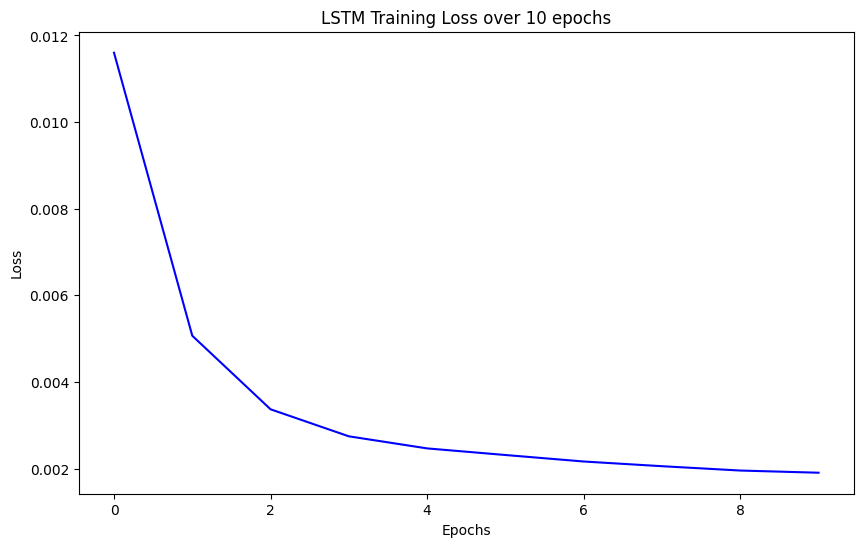

In [ ]:
model = LSTM(input_size, hidden_size, num_layers, condition_size, output_size)
# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()
# Move model to CUDA if available
model = model.to(device)
lstm_training_loss_new = train(model, train_loader_new, num_epochs, optimizer, loss_fn, model_name='LSTM', device=device, plot=True)

In [ ]:
# Save the model
torch.save(model.state_dict(), 'LSTM_model_new.pth')
predictions, _ = test(model, test_loader_new)

Test Loss: 0.0002734304071054794


Epoch 1, Training Loss: 0.007830857542867805
Epoch 2, Training Loss: 0.004205117004085279
Epoch 3, Training Loss: 0.0035326904333587063
Epoch 4, Training Loss: 0.003154627445067144
Epoch 5, Training Loss: 0.002855643008198578
Epoch 6, Training Loss: 0.002602380262811941
Epoch 7, Training Loss: 0.002426772424990973
Epoch 8, Training Loss: 0.0022671365140653392
Epoch 9, Training Loss: 0.0021696573560498244
Epoch 10, Training Loss: 0.0021336412661114583


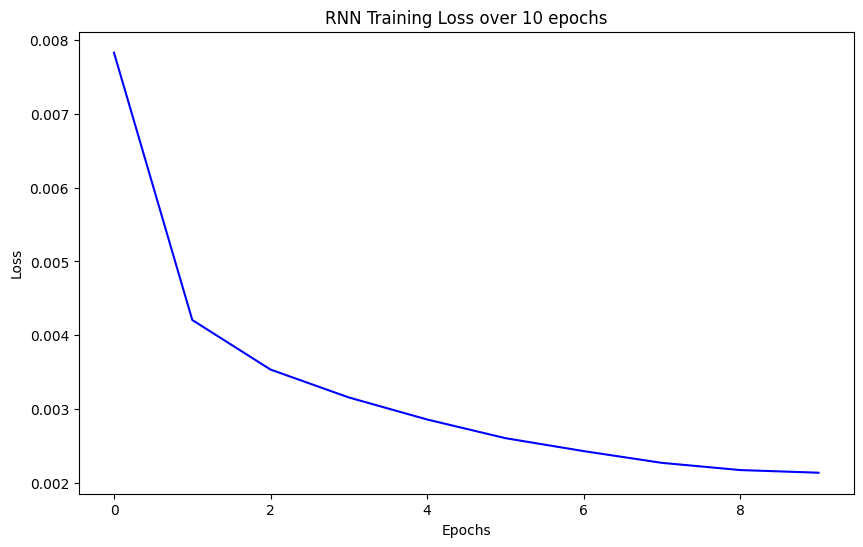

In [ ]:
model = RNN(input_size, hidden_size, num_layers, condition_size, output_size)
# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()
# Move model to CUDA if available
model = model.to(device)
rnn_training_loss_new = train(model, train_loader_new, num_epochs, optimizer, loss_fn, model_name='RNN', device=device, plot=True)

In [ ]:
# Save the model
torch.save(model.state_dict(), 'RNN_model_new.pth')
predictions, _ = test(model, test_loader_new)

Test Loss: 0.0002690929565384674


Epoch 1, Training Loss: 0.010467174581444562
Epoch 2, Training Loss: 0.004267731789573739
Epoch 3, Training Loss: 0.0035498159108358286
Epoch 4, Training Loss: 0.0031543483303997128
Epoch 5, Training Loss: 0.0029109972773620272
Epoch 6, Training Loss: 0.0026491865919317397
Epoch 7, Training Loss: 0.0024492006771140366
Epoch 8, Training Loss: 0.0023203872737262527
Epoch 9, Training Loss: 0.0021656227003557945
Epoch 10, Training Loss: 0.002062963938610219


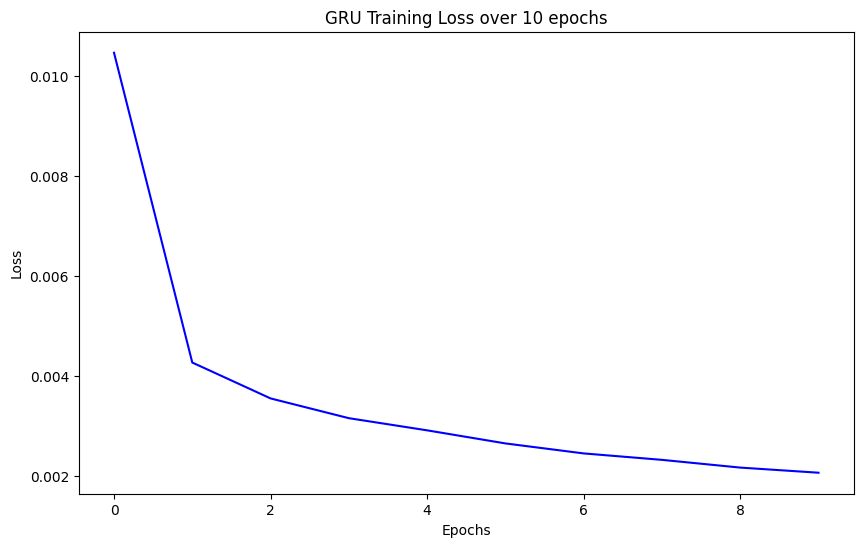

In [ ]:
model = GRU(input_size, hidden_size, num_layers, condition_size, output_size)
# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()
# Move model to CUDA if available
model = model.to(device)
gru_training_loss_new = train(model, train_loader_new, num_epochs, optimizer, loss_fn, model_name='GRU', device=device, plot=True)

In [ ]:
# Save the model
torch.save(model.state_dict(), 'GRU_model_new.pth')
predictions, _ = test(model, test_loader_new)

Test Loss: 0.0002814750732795801


## Test loss comparison analysis

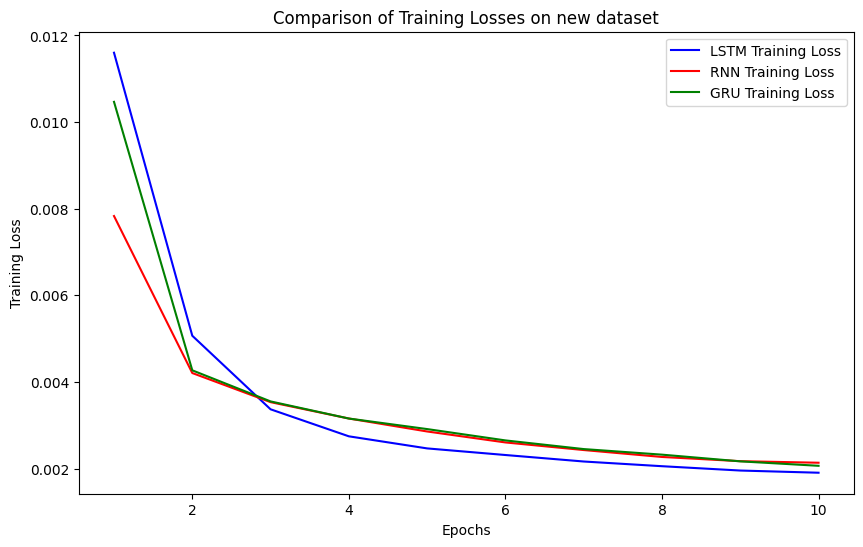

In [ ]:
# Plot training losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), lstm_training_loss_new, label='LSTM Training Loss', color='blue')
plt.plot(range(1, num_epochs+1), rnn_training_loss_new, label='RNN Training Loss', color='red')
plt.plot(range(1, num_epochs+1), gru_training_loss_new, label='GRU Training Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Comparison of Training Losses on new dataset')
plt.legend()
plt.show()

Test Loss: 0.0002734304071054794
Test Loss: 0.0002690929565384674
Test Loss: 0.0002814750732795801


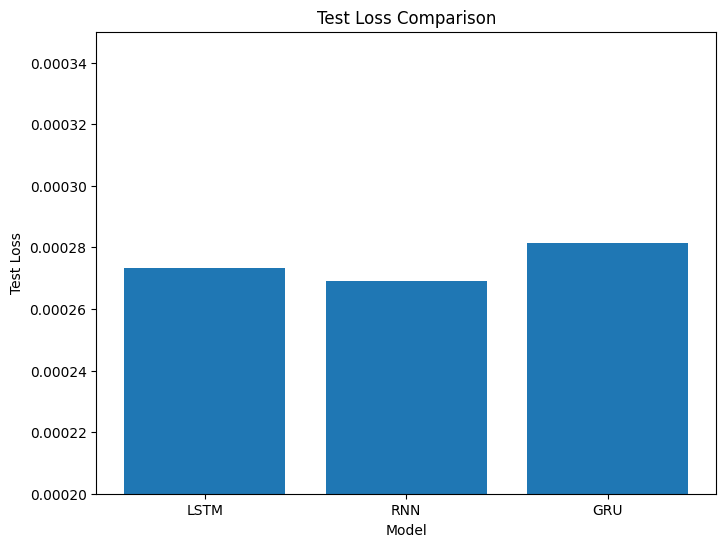

In [ ]:
lstm_model = LSTM(input_size, hidden_size, num_layers, condition_size, output_size).to(device)
state_dict = torch.load('LSTM_model_new.pth')
lstm_model.load_state_dict(state_dict)

rnn_model = RNN(input_size, hidden_size, num_layers, condition_size, output_size).to(device)
state_dict = torch.load('RNN_model_new.pth')
rnn_model.load_state_dict(state_dict)

gru_model = GRU(input_size, hidden_size, num_layers, condition_size, output_size).to(device)
state_dict = torch.load('GRU_model_new.pth')
gru_model.load_state_dict(state_dict)

_, test_loss_lstm = test(lstm_model, test_loader_new)
_, test_loss_rnn = test(rnn_model, test_loader_new)
_, test_loss_gru = test(gru_model, test_loader_new)

# Test losses
test_losses = [test_loss_lstm, test_loss_rnn, test_loss_gru]
models = ['LSTM', 'RNN', 'GRU']

# Create bar plot
plt.figure(figsize=(8, 6))
plt.bar(models, test_losses)
plt.xlabel('Model')
plt.ylabel('Test Loss')
# Set the y-axis limits
plt.ylim(0.00020, 0.00035)
plt.title('Test Loss Comparison')
plt.show()

## All models loss Summary

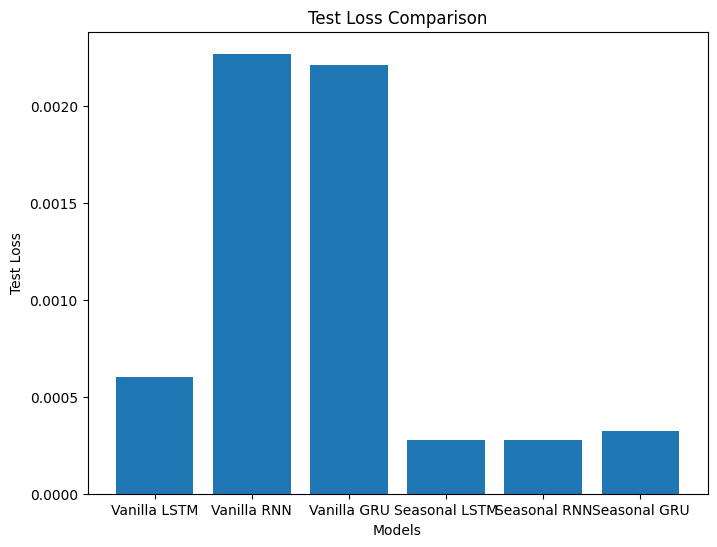

In [ ]:
test_loss_summary = [0.000601, 0.00227, 0.00221, 0.000277, 0.000276, 0.000323]
models = ['Vanilla LSTM', 'Vanilla RNN', 'Vanilla GRU', 'Seasonal LSTM', 'Seasonal RNN', 'Seasonal GRU' ]
# Create bar plot
plt.figure(figsize=(8, 6))
plt.bar(models, test_loss_summary)
plt.xlabel('Models')
plt.ylabel('Test Loss')
# Set the y-axis limits
# plt.ylim(0.00020, 0.00035)
plt.title('Test Loss Comparison')
plt.show()

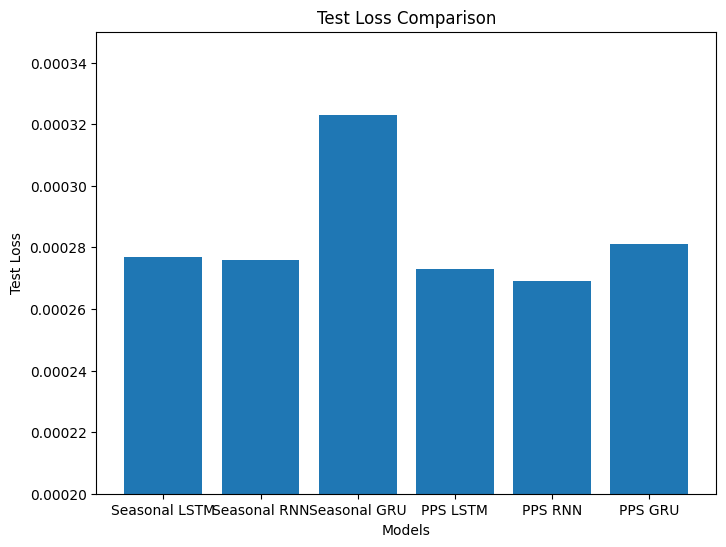

In [ ]:
test_loss_summary = [0.000277, 0.000276, 0.000323, 0.000273, 0.000269, 0.000281]
models = ['Seasonal LSTM', 'Seasonal RNN', 'Seasonal GRU', 'PPS LSTM', 'PPS RNN', 'PPS GRU' ]
# Create bar plot
plt.figure(figsize=(8, 6))
plt.bar(models, test_loss_summary)
plt.xlabel('Models')
plt.ylabel('Test Loss')
# Set the y-axis limits
plt.ylim(0.00020, 0.00035)
plt.title('Test Loss Comparison')
plt.show()